In [14]:
# Darts context size scaling
import os

# compare the NLL/D for the predictions of the different models
from collections import defaultdict
import seaborn as sns
from data.metrics import calculate_crps
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from data.small_context import get_datasets
sns.set_style("whitegrid")
import matplotlib 
matplotlib.rcParams.update({'font.size': 18})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})

hue_order = ['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA','GPT-3']
palette = sns.color_palette('Dark2', len(hue_order))
palette = palette[:2] + palette[3:] + palette[2:3]

avg_nlls = defaultdict(list)
crps = defaultdict(list)
mae = defaultdict(list)
datasets = get_datasets()
for train_frac in [0.1, 0.2, 0.5, 1]:
    if train_frac == 1:
        output_dir = '../precomputed_outputs/subsample/small_context_tuned'
    else:
        output_dir = f'../precomputed_outputs/subsample/small_context_tuned_{train_frac}'

    nlls = defaultdict(dict)
    for dsname,(train,test) in datasets.items():
        with open(f'{output_dir}/{dsname}.pkl','rb') as f:
            data_dict = pickle.load(f)
        for model_name,preds in data_dict.items():
            if model_name in ['ada', 'babbage', 'curie']:
                continue
            if 'NLL/D' not in preds:
                continue
            nll = preds['NLL/D']
            if model_name == 'text-davinci-003':
                model_name = 'GPT-3'
            nlls[model_name][dsname] = nll
    # update with new runs
    output_dir = f'eval/small_context_tuned_new_{train_frac}' if train_frac < 1 else 'eval/small_context_tuned'
    for dsname,(train,test) in datasets.items():
        if os.path.exists(f'{output_dir}/{dsname}.pkl'):
            with open(f'{output_dir}/{dsname}.pkl','rb') as f:
                data_dict = pickle.load(f)
            for model_name,preds in data_dict.items():
                if model_name not in ['gp']:
                    continue
                if model_name in ['ada', 'babbage', 'curie']:
                    continue
                if 'NLL/D' not in preds:
                    continue
                nll = preds['NLL/D']
                if model_name == 'text-davinci-003':
                    model_name = 'GPT-3'
                print(f'Updated {model_name} {dsname} [{train_frac}]: {nlls[model_name][dsname]} --> {nll}')
                nlls[model_name][dsname] = nll
    avg_nlls[train_frac] = {k: np.array(list(v.values())).mean() for k,v in nlls.items()}
    
df = pd.DataFrame(avg_nlls)
df = df.reset_index().rename(columns={'index':'Model'})
# drop arima model
# plot a line at arima
arima_nll = df[df['Model'] == 'arima'][1].values[0]

df = df[df['Model'] != 'arima']
# change gp to GP
df['Model'] = df['Model'].apply(lambda x: 'SM-GP' if x == 'gp' else x)

df = df.melt(id_vars=['Model'], var_name='Train Fraction', value_name='NLL/D')

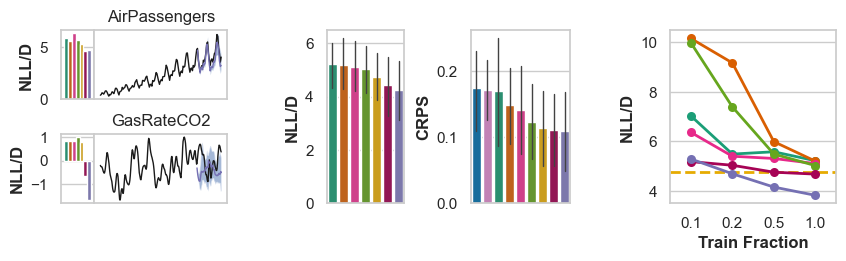

['SM-GP', 'N-BEATS', 'TCN', 'N-HiTS', 'ARIMA', 'LLMTime\n(LLaMA)', 'LLMTime\n(GPT-3)', 'PromptCast\n(LLaMA)', 'PromptCast\n(GPT-3)']


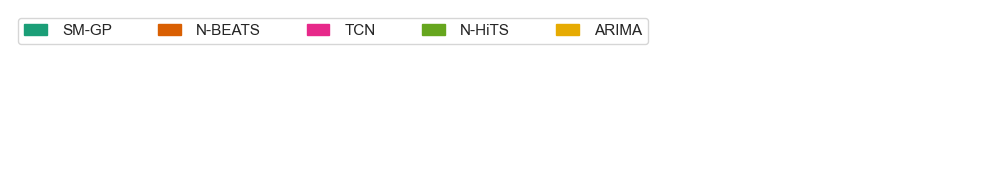

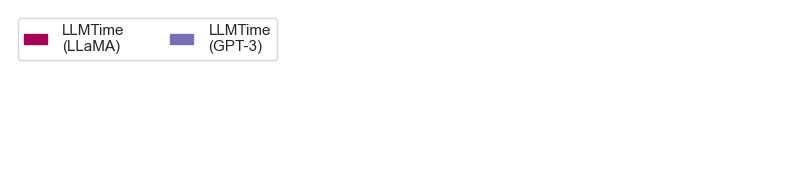

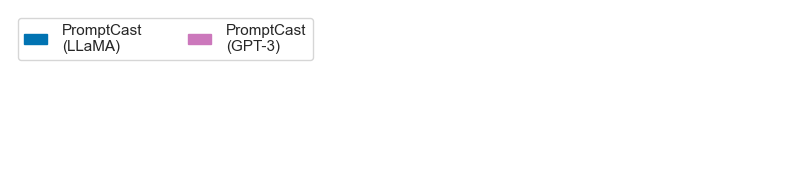

In [22]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

import sys
sys.path.append("..")
from data.small_context import get_datasets

sns.set(style="whitegrid", font_scale=1.)

datasets = get_datasets()

fig = plt.figure(figsize=(10, 2.25))
gs = GridSpec(
    2, 8, figure=fig, 
    width_ratios=[2, 8, 6, 7/1.5, 4, 9/1.5, 6, 10], 
    wspace=0.0, hspace=0.5
)

ax = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[:, 3]),
    fig.add_subplot(gs[:, 5]),
    fig.add_subplot(gs[:, 7]),
]

name_order = ['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA','LLaMA-2 70B','GPT-3']
palette = sns.color_palette('Dark2', len(name_order))
palette = palette[:2] + palette[3:6] + ['#a60355'] + palette[2:3]

datasets_to_plot = [
    'AirPassengersDataset', 
    'GasRateCO2Dataset',
]

csv_fn = "../precomputed_outputs/deterministic_csvs/darts_results_agg.csv"
df = pd.read_csv(csv_fn)

ax_idx = 0
# Iterate through the datasets and plot the samples
for idx, dsname in enumerate(datasets_to_plot):
    train,test = datasets[dsname]

    pkl_fn = f"../precomputed_outputs/darts/{dsname}.pkl"
    with open(pkl_fn,'rb') as f:
        data_dict = pickle.load(f)

    if not 'text-davinci-003' in data_dict:
        continue
    samples = data_dict['text-davinci-003']['samples']
    lower = samples.quantile(0.1,axis=0)
    upper = samples.quantile(0.9,axis=0)
    
    pred_color = sns.color_palette('Dark2')[2]
    train_test = pd.concat([train,test])

    ax[2*idx+1].plot(train_test, color='k',label='Ground Truth', linewidth=1)
    ax[2*idx+1].fill_between(samples.iloc[0].index, lower, upper, alpha=0.5)
    ax[2*idx+1].plot(samples.iloc[0].index, data_dict['text-davinci-003']['median'], color=pred_color,label='GPT3 Median',linewidth=1)
    # ax[2*idx+1].set_xlabel(dsname.replace("Dataset",""))
    ax[2*idx+1].get_yaxis().set_visible(False)
    # ax[2*idx+1].get_xaxis().set_visible(False)
    ax[2*idx+1].set_title(dsname.replace("Dataset",""))


    import matplotlib.dates as mdates
    myFmt = mdates.DateFormatter('%d')
    # ax[2*idx+1].xaxis.set_major_formatter(myFmt)
    # ax[2*idx+1].xaxis.set_major_locator(plt.MaxNLocator(2))
    # ax.set_xticklabels([0, 0, len(train_test) // 2, len(train_test)])
    
    # palette = sns.color_palette('Dark2', len(hue_order))
    # palette = palette[:2] + palette[3:-1] + ['#a60355'] + palette[2:3]

    sns.barplot(
        x='Dataset',
        # x='data_type',
        # order=['Trend', 'Periodic', 'Trend + Periodic'],
        y='NLL/D',
        hue='Type', 
        hue_order=name_order,
        data=df[df['Dataset'] == dsname.replace("Dataset","")], 
        ax=ax[2*idx], 
        palette=palette,
    )

    ax[2*idx].get_legend().remove()


gpt_color = sns.color_palette('Dark2',3)[2]

name_order = ['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA','LLaMA-2 70B','GPT-3']
palette = sns.color_palette('Dark2', len(name_order))
palette = palette[:2] + palette[3:6] + ['#a60355'] + palette[2:3]

csv_fn = "../precomputed_outputs/deterministic_csvs/promptcast_comparison.csv"
promptcast_df = pd.read_csv(csv_fn)
promptcast_df['Type'] = promptcast_df['model_name']
promptcast_df['CRPS'] = promptcast_df['crps']

promptcast_palette = sns.color_palette('colorblind', 5)
promptcast_palette = [
    promptcast_palette[0], 
    promptcast_palette[-1], 
    '#a60355', 
    gpt_color
]
model_names = [
    'PromptCast\n(LLaMA)', 'PromptCast\n(GPT-3)', 
    'LLMTime\n(LLaMA)', 'LLMTime\n(GPT-3)',
]


c = sns.barplot(
    data=df,
    order=name_order,#['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA','GPT-3','LLaMA70B'],
    x='Type',
    y='NLL/D',
    ax=ax[4], 
    color="grey",
    palette=palette,
    # edgecolor='black',
    errwidth=1.,
    errorbar=('ci', 68)
)

name_order = [
    'PromptCast\n(GPT-3)', 'PromptCast\n(LLaMA)',
    'N-BEATS', 'SM-GP','TCN','N-HiTS','ARIMA',
    'LLaMA-2 70B','GPT-3'
]
c = sns.barplot(
    data=pd.concat([promptcast_df, df]),
    order= name_order,#['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA','GPT-3','LLaMA70B'],
    x='Type',
    y='CRPS',
    ax=ax[5], 
    color="grey",
    palette=promptcast_palette[:2] + palette,
    # edgecolor='black',
    errwidth=1.,
    errorbar=('ci', 68)
)

for a in ax:
    a.set_xlabel('')
    a.set_xticklabels([])
    a.set_xticks([])

ax[4].set_ylabel("NLL/D")
ax[5].set_ylabel("CRPS")

name_order = ['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA','LLaMA-2 70B','GPT-3']
csv_fn = "../precomputed_outputs/deterministic_csvs/subsampling_results.csv"
df = pd.read_csv(csv_fn)

sns.pointplot(
    x='Train Fraction', 
    y='NLL/D', 
    hue='Model',
    data=df, 
    palette=palette, 
    hue_order=name_order,
    ax=ax[6],
)
ax[6].axhline(arima_nll, linestyle='--', label='ARIMA', color=palette[-3], linewidth=4)
ax[6].set_ylim(3.5,10.5)
# plt.ylabel('NLL/Dimension')

#change all linewidths to 2
for l in ax[6].lines:
    l.set_linewidth(2)

#change point sizes to 100
for c in ax[6].collections:
    c.set_sizes([20])

#turn legend off
ax[6].get_legend().remove()

fig.savefig('outputs/darts_results.svg', bbox_inches='tight')
plt.show()


combined_palette = palette + promptcast_palette[:2]
combined_names = name_order[:-2] + model_names[2:] + model_names[:2]
print(combined_names)
#make legend using palette and model names
handles = []
for i, m in enumerate(combined_names):
    handles.append(
        mpatches.Patch(color=combined_palette[i], label=m)
    )
labels = combined_names

fig, ax = plt.subplots(
    1, 1, 
    figsize=(10, 2), 
)
ax.axis('off')

leg = ax.legend(
    handles=handles[:5],
    labels=labels[:5],
    loc='upper left',
    # fontsize=9,
    handlelength=1.5,
    # bbox_to_anchor=(0.2, -0.28),
    columnspacing=3, 
    handletextpad=1.,
    frameon=True,
    ncols=5
)

plt.tight_layout()
fig.savefig('outputs/darts_legend_1.svg', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(
    1, 1, 
    figsize=(10, 2), 
)
ax.axis('off')

leg = ax.legend(
    handles=handles[5:7],
    labels=labels[5:7],
    loc='upper left',
    # fontsize=9,
    handlelength=1.5,
    # bbox_to_anchor=(0.2, -0.28),
    columnspacing=3, 
    handletextpad=1.,
    frameon=True,
    ncols=5
)

fig.savefig('outputs/darts_legend_2.svg', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(
    1, 1, 
    figsize=(10, 2), 
)
ax.axis('off')

leg = ax.legend(
    handles=handles[7:9],
    labels=labels[7:9],
    loc='upper left',
    # fontsize=9,
    handlelength=1.5,
    # bbox_to_anchor=(0.2, -0.28),
    columnspacing=3, 
    handletextpad=1.,
    frameon=True,
    ncols=5
)

#put (a) above the first 3 subplots
# ax[0].text(1, -0.2, '(a)', transform=ax[0].transAxes, size=14, weight='bold')
# ax[0].text(4.5, -0.2, '(b)', transform=ax[0].transAxes, size=14, weight='bold')

fig.savefig('outputs/darts_legend_3.svg', bbox_inches='tight')
plt.show()